# 3. Synthetic Pumping Test - Calibration test

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import ttim

### Use observation times from Oude Korendijk

In [2]:
drawdown = np.loadtxt("data/oudekorendijk_h30.dat")
tobs = drawdown[:, 0] / 60 / 24
robs = 30
Q = 788

### Generate data

In [3]:
ml = ttim.ModelMaq(kaq=60, z=(-18, -25), Saq=1e-4, tmin=1e-5, tmax=1)
w = ttim.Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=0)
ml.solve()
rnd = np.random.default_rng(2)
hobs = ml.head(robs, 0, tobs)[0] + 0.05 * rnd.random(len(tobs))

self.neq  1
solution complete


### See if TTim can find aquifer parameters back

In [ ]:
cal = ttim.Calibrate(ml)
cal.set_parameter(name="kaq0", layers=0, initial=100)
cal.set_parameter(name="Saq0", layers=0, initial=1e-3)
cal.series(name="obs1", x=robs, y=0, layer=0, t=tobs, h=hobs)
cal.fit()

..................................
Fit succeeded.


In [5]:
cal.parameters

,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq0,0,59.871288,0.670178,1.119365,-inf,inf,100.000,None,[59.871287575268404]
Saq0,0,0.000121,0.000004,3.633643,-inf,inf,0.001,None,[0.00012118965722715004]


In [6]:
print("rmse:", cal.rmse())

rmse: 0.014201293661013786


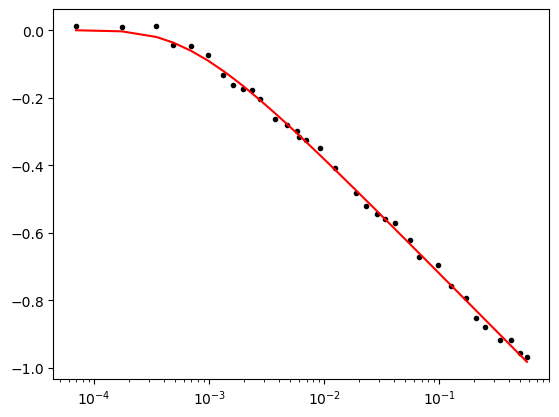

In [7]:
hm = ml.head(robs, 0, tobs, 0)
plt.semilogx(tobs, hobs, ".k")
plt.semilogx(tobs, hm[0], "r");

In [8]:
print("correlation matrix")
print(cal.fitresult.covar)

correlation matrix
[[ 4.49139190e-01 -2.49689096e-06]
 [-2.49689096e-06  1.93916909e-11]]


Fit with `scipy.least_squares` (not recommended)

In [9]:
cal = ttim.Calibrate(ml)
cal.set_parameter(name="kaq0", layers=0, initial=100)
cal.set_parameter(name="Saq0", layers=0, initial=1e-3)
cal.series(name="obs1", x=robs, y=0, layer=0, t=tobs, h=hobs)
cal.fit_least_squares(report=True)

..........................................
      layers    optimal       std  perc_std  pmin  pmax  initial inhoms  \
kaq0       0  59.870969  0.660661  1.103474  -inf   inf  100.000   None   
Saq0       0   0.000121  0.000004  3.587586  -inf   inf    0.001   None   

                        parray  
kaq0       [59.87096932924763]  
Saq0  [0.00012119340200370668]  
[6.60660677e-01 4.34791694e-06]
[[ 4.36472531e-01 -2.42866203e-06]
 [-2.42866203e-06  1.89043817e-11]]
[[ 1.         -0.84548788]
 [-0.84548788  1.        ]]


## Calibrate parameters in multiple layers
Example showing how parameters can be optimized when multiple layers share the same parameter value.

In [10]:
ml = ttim.ModelMaq(
    kaq=[10.0, 10.0],
    z=(-10, -16, -18, -25),
    c=[10.0],
    Saq=[0.1, 1e-4],
    tmin=1e-5,
    tmax=1,
)
w = ttim.Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=1)
ml.solve()
hobs0 = ml.head(robs, 0, tobs, layers=[0])[0]
hobs1 = ml.head(robs, 0, tobs, layers=[1])[0]

self.neq  1
solution complete


In [11]:
cal.parameters

,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq0,0,59.870969,0.660661,1.103474,-inf,inf,100.000,None,[59.87096932924763]
Saq0,0,0.000121,0.000004,3.587586,-inf,inf,0.001,None,[0.00012119340200370668]


In [ ]:
cal = ttim.Calibrate(ml)
cal.set_parameter(
    name="kaq0_1", layers=[0, 1], initial=20.0, pmin=0.0, pmax=30.0
)  # layers 0 and 1 have the same k-value
cal.set_parameter(name="Saq0", layers=0, initial=1e-3, pmin=1e-5, pmax=0.2)
cal.set_parameter(name="Saq1", layers=1, initial=1e-3, pmin=1e-5, pmax=0.2)
cal.set_parameter(name="c1", layers=1, initial=1.0, pmin=0.1, pmax=200.0)
cal.series(name="obs0", x=robs, y=0, layer=0, t=tobs, h=hobs0)
cal.series(name="obs1", x=robs, y=0, layer=1, t=tobs, h=hobs1)
cal.fit(report=False)
display(cal.parameters)

....................................................................................................................
Fit succeeded.


,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq0_1,"[0, 1]",9.998813,3.275126e-04,0.003276,0.00000,30.0,20.000,None,"[9.998812542977381, 9.998812542977381]"
Saq0,0,0.100010,1.041096e-07,0.000104,0.00001,0.2,0.001,None,"[0.10000993019005114, 9.999506259756452e-05]"
Saq1,1,0.000100,1.175972e-09,0.001176,0.00001,0.2,0.001,None,[9.999506259756452e-05]
c1,1,9.999649,9.921790e-05,0.000992,0.10000,200.0,1.000,None,[9.999649350868319]


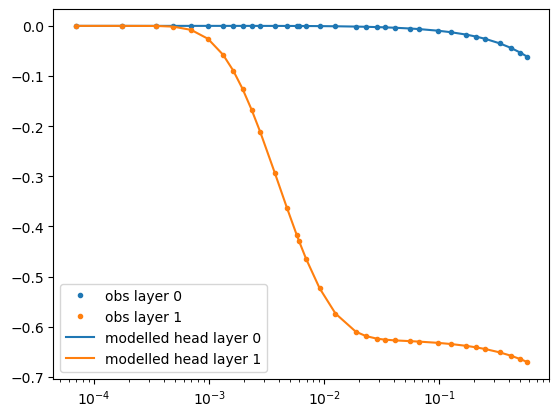

In [13]:
plt.semilogx(tobs, hobs0, ".C0", label="obs layer 0")
plt.semilogx(tobs, hobs1, ".C1", label="obs layer 1")

hm = ml.head(robs, 0, tobs)
plt.semilogx(tobs, hm[0], "C0", label="modelled head layer 0")
plt.semilogx(tobs, hm[1], "C1", label="modelled head layer 1")

plt.legend(loc="best");

### Generate data for head measured in well

In [14]:
tobs2 = np.hstack((tobs, np.arange(0.61, 1, 0.01)))

In [15]:
ml = ttim.ModelMaq(kaq=60, z=(-18, -25), Saq=1e-4, tmin=1e-5, tmax=1)
w = ttim.Well(ml, xw=0, yw=0, rw=0.3, res=0.02, tsandQ=[(0, 788), (0.6, 0)], layers=0)
ml.solve()
rnd = np.random.default_rng(2)
hobs2 = w.headinside(tobs2)[0] + 0.05 * rnd.random(len(tobs2))

self.neq  1
solution complete


In [ ]:
cal = ttim.Calibrate(ml)
cal.set_parameter(name="kaq0", layers=0, initial=100)
cal.set_parameter(name="Saq0", layers=0, initial=1e-3)
cal.set_parameter_by_reference(name="res", parameter=w.res[:], initial=0.05)
cal.seriesinwell(name="obs1", element=w, t=tobs2, h=hobs2)
cal.fit()

....................................................................................................................................................................................................................................................................................................................................................................................................................
Fit succeeded.


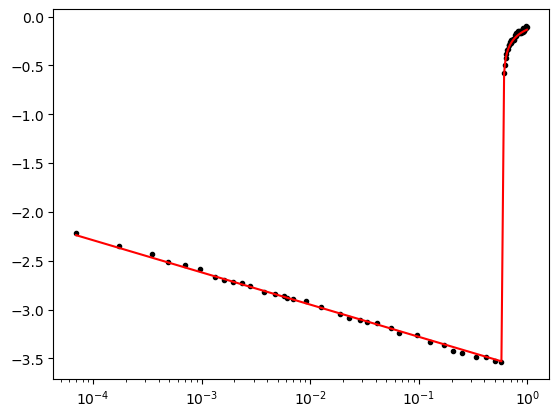

In [17]:
hm = w.headinside(tobs2)
plt.semilogx(tobs2, hobs2, ".k")
plt.semilogx(tobs2, hm[0], "r");